In [2]:
import ssl
ssl._create_default_https_context = ssl._create_unverified_context

from sentinelhub import SHConfig
from sentinelhub import (
    CRS,
    BBox,
    DataCollection,
    DownloadRequest,
    MimeType,
    MosaickingOrder,
    SentinelHubDownloadClient,
    SentinelHubRequest,
    bbox_to_dimensions,
)
import folium
from tqdm import tqdm
import math

In [3]:
from sentinelhub import SHConfig
from dotenv import load_dotenv
import os
import numpy as np
import datetime
import os
import matplotlib.pyplot as plt
from sentinelhub import CRS, BBox, bbox_to_dimensions
import cv2
import ee

In [4]:
config_sentinel = SHConfig(sh_client_id=os.environ.get("sh_client_id"), sh_client_secret=os.environ.get("sh_client_secret"))

In [5]:
evalscript_lsm = """
function setup() {
  return {
    input: ["B02", "B03", "B04", "B08", "B11"],
    output: { bands: 3 },
  };
}

function stretch(val, min, max) { return (val - min) / (max - min); }

function evaluatePixel(sample) {
  var bsi = ((sample.B11 + sample.B04) - (sample.B08 + sample.B02)) / ((sample.B11 + sample.B04) + (sample.B08 + sample.B02));
  var NDVI = index(sample.B08, sample.B04);
  var NDWI = index(sample.B03, sample.B08);
  
  // Cloud filtering: Brightness threshold and band ratios
  var brightness = (sample.B02 + sample.B03 + sample.B04) / 3; // Visible brightness
  var cloud_ratio = sample.B11 / sample.B08; // Higher values indicate possible clouds

  if (brightness > 0.25 && cloud_ratio > 1.2) {
    return [0.8, 0.8, 0.8]; // Light gray to minimize cloud impact
  }

  // Set unavailable regions to black (e.g., non-land areas, invalid data)
  if (!isFinite(bsi) || !isFinite(NDVI) || !isFinite(NDWI) || sample.B02 === 0) {
    return [0, 0, 0]; // Black
  }

  if (NDWI > 0.15) {
    return [0, 0.2, 1.0 * NDWI];
  }
  if ((sample.B11 > 0.95) || (NDVI < 0.1)) {
    return [1.5, 0.7, -1];
  }
  //if (NDVI > 0.25) {
  //  return [0, 0.2 * NDVI, 0];
  ////} else {
  //  return [3.5 * bsi, 0.3, 0];
  //}
}
"""

In [6]:
from math import cos, radians

def add_km_to_coordinates(lat, lon, d_lat_km, d_lon_km):
    km_per_deg_lat = 111.32  # Constant
    km_per_deg_lon = 111.32 * cos(radians(lat))  # Adjusted for latitude
    new_lat = lat + (d_lat_km / km_per_deg_lat) # Convert km to degrees
    new_lon = lon + (d_lon_km / km_per_deg_lon)

    return new_lat, new_lon

In [7]:
grid = 10
box_dim = 400 #450 km
min_lat, min_lon  = 6.763053, 66.278948

# max_lat, max_lon = add_km_to_coordinates(min_lat, min_lon, box_dim, box_dim)
max_lat, max_lon = add_km_to_coordinates(min_lat, min_lon, box_dim * (grid - 1), box_dim * (grid - 1))

lat = [add_km_to_coordinates(min_lat, min_lon, i * box_dim, 0)[0] for i in range(grid)]
lon = [add_km_to_coordinates(min_lat, min_lon, 0, i * box_dim)[1] for i in range(grid)]

latlons = []
for i in range(len(lat)-1):
    for k in range(len(lon)-1):
        latlons.append((lat[k], lon[i], lat[k+1], lon[i+1]))

m = folium.Map(
    location=[(min_lat + max_lat) / 2, (min_lon + max_lon) / 2],
    zoom_start=4,
    tiles='https://server.arcgisonline.com/ArcGIS/rest/services/World_Imagery/MapServer/tile/{z}/{y}/{x}',
    attr='Esri'
)

cordinates = []
for k in latlons:
    cord = [(k[0], k[1]), (k[2], k[3])]
    cordinates.append([k[1], k[0], k[3], k[2]])
    folium.Rectangle(cord, color='red', fill='pink',fill_opcity=0.5).add_to(m)
m

In [71]:
def get_suseptibility_mapping(cordinates, box_dim=400, date_start = "2024-04-12", date_end = "2024-04-12"):
    min_lat, min_lon  = cordinates

    max_lat, max_lon = add_km_to_coordinates(min_lat, min_lon, box_dim, box_dim)

    cords = [min_lon, min_lat, max_lon, max_lat]

    bbox = BBox(bbox=cords, crs=CRS.WGS84)
    size = bbox_to_dimensions(bbox, resolution=box_dim*1000/2300)

    request_lms_color = SentinelHubRequest(
            evalscript=evalscript_lsm,
            input_data=[
                SentinelHubRequest.input_data(
                    data_collection=DataCollection.SENTINEL2_L1C,
                    time_interval=(date_start, date_end),
                )
            ],
            responses=[SentinelHubRequest.output_response("default", MimeType.PNG)],
            bbox=bbox,
            size=size,
            config=config_sentinel,
        )

    lms_response = request_lms_color.get_data()
    return lms_response[0]

# lms_mapping = get_suseptibility_mapping([cordinates[0][:2][1], cordinates[0][:2][0]])

In [157]:
import numpy as np

grid = 10  # Example value
canvas = np.zeros((1000 * grid, 1000 * grid, 3), dtype=np.uint8)

row = grid - 1  # Start from bottom row
col = 0         # Start from leftmost column
correction = 0
for idx, i in enumerate(cordinates):
    y_start = 1000 * row
    y_end = 1000 * (row + 1)
    x_start = 1000 * col
    x_end = 1000 * (col + 1)

    image = get_suseptibility_mapping((i[:2][1], i[:2][0] + correction))
    print(y_start, y_end, x_start, x_end)
    print(i[:2][1], i[:2][0], end="\n")
    canvas[y_start:y_end, x_start:x_end] = cv2.resize(image, (1000,1000))
    plt.imsave("mapping4.png", canvas)

    row -= 1  # Move upwards
    if row < 0:  # If we reach the top
        correction = 0.3
        row = grid - 1  # Reset to bottom
        col += 1  # Move right

9000 10000 0 1000
6.763053 66.278948
8000 9000 0 1000
10.356297699964069 66.278948
7000 8000 0 1000
13.949542399928136 66.278948
6000 7000 0 1000
17.5427870998922 66.278948
5000 6000 0 1000
21.136031799856273 66.278948
4000 5000 0 1000
24.729276499820337 66.278948
3000 4000 0 1000
28.322521199784404 66.278948
2000 3000 0 1000
31.915765899748475 66.278948
1000 2000 0 1000
35.509010599712546 66.278948
0 1000 0 1000
6.763053 69.89737093849098
9000 10000 1000 2000
10.356297699964069 69.89737093849098
8000 9000 1000 2000
13.949542399928136 69.89737093849098
7000 8000 1000 2000
17.5427870998922 69.89737093849098
6000 7000 1000 2000
21.136031799856273 69.89737093849098
5000 6000 1000 2000
24.729276499820337 69.89737093849098
4000 5000 1000 2000
28.322521199784404 69.89737093849098
3000 4000 1000 2000
31.915765899748475 69.89737093849098
2000 3000 1000 2000
35.509010599712546 69.89737093849098
1000 2000 1000 2000
6.763053 73.51579387698196
0 1000 1000 2000
10.356297699964069 73.51579387698196


KeyboardInterrupt: 

In [150]:
canvas[y_start:y_end, x_start:x_end] = cv2.resize(image, (1000,1000))

ValueError: could not broadcast input array from shape (1000,1000,3) into shape (999,1000,3)

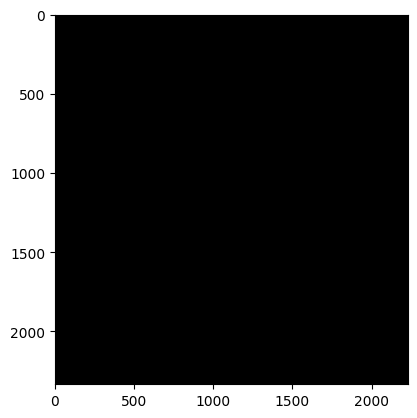

In [158]:
lms_mapping1 = get_suseptibility_mapping([cordinates[13][:2][1], cordinates[13][:2][0]])
plt.imshow(lms_mapping1)

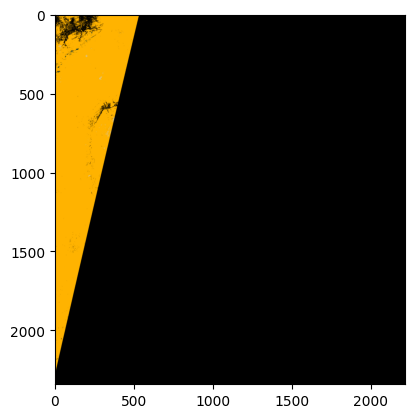

In [159]:
lms_mapping2 = get_suseptibility_mapping([cordinates[14][:2][1], cordinates[14][:2][0]])
plt.imshow(lms_mapping2)

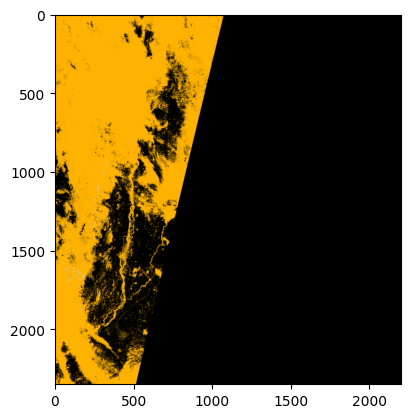

In [160]:
lms_mapping3 = get_suseptibility_mapping([cordinates[15][:2][1], cordinates[15][:2][0]])
plt.imshow(lms_mapping3)

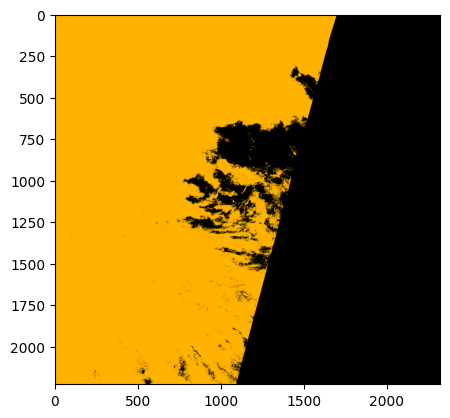

In [162]:
lms_mapping4 = get_suseptibility_mapping([cordinates[16][:2][1], cordinates[16][:2][0]])
plt.imshow(lms_mapping4)

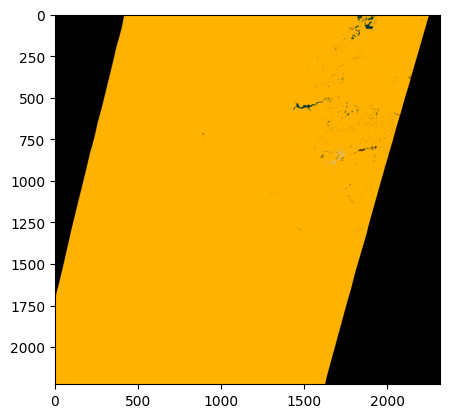

In [164]:
lms_mapping5 = get_suseptibility_mapping([cordinates[17][:2][1], cordinates[17][:2][0]])
plt.imshow(lms_mapping5)

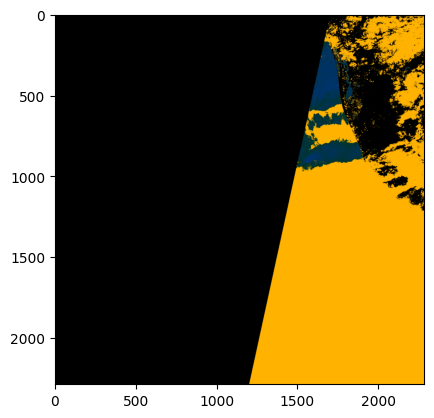

In [165]:
lms_mapping6 = get_suseptibility_mapping([cordinates[18][:2][1], cordinates[18][:2][0]])
plt.imshow(lms_mapping6)

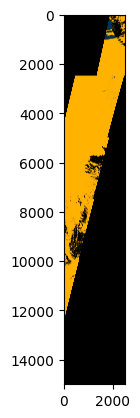

In [166]:
canvas = np.zeros((2500*6, 2500, 3)).astype(np.uint8)
canvas[:2500, :] = cv2.resize(lms_mapping6, (2500, 2500))
canvas[2500:5000, :] = cv2.resize(lms_mapping5, (2500, 2500))
canvas[5000:7500, :] = cv2.resize(lms_mapping4, (2500, 2500))
canvas[7500:10000, :] = cv2.resize(lms_mapping3, (2500, 2500))
canvas[10000:12500, :] = cv2.resize(lms_mapping2, (2500, 2500))
canvas[12500:15000, :] = cv2.resize(lms_mapping1, (2500, 2500))
plt.imshow(canvas)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


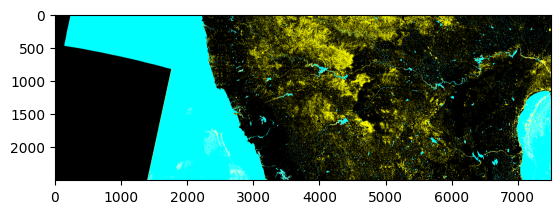

In [75]:
canvas = np.zeros((2500, 7500, 3))
canvas[:, :2500] = cv2.resize(lms_mapping1, (2500, 2500))
canvas[:, 2500:5000] = cv2.resize(lms_mapping2, (2500, 2500))
canvas[:, 5000:] = cv2.resize(lms_mapping3, (2500, 2500))
plt.imshow(canvas)

In [25]:
box_dim / 75

5.333333333333333

In [ ]:
box_dim/

In [27]:
correction = 85

tiles = int(math.sqrt(len(cordinates)))  
grid_size = 1000
image_size = grid_size * tiles
canvas = np.zeros((image_size, image_size, 3))

for col in range(2, grid+1):
    for i in range(grid-1):  
        if i != 0:
            min_lon, _ = add_km_to_coordinates(cordinates[grid-col + i*(grid-1)][:2][0], 0, correction, 0) # Lat correction
        else:
            lat_correction = 0
            min_lon = cordinates[grid-col + i*(grid-1)][:2][0]
        min_lat = cordinates[grid-col + i*(grid-1)][:2][1]
        # min_lon = cordinates[grid-col + i*(grid-1)][:2][0]  
        print(min_lat, min_lon)
        image = get_suseptibility_mapping([min_lat, min_lon])
        canvas[(col-2)*grid_size:(col-1)*grid_size, i*grid_size:(i+1)*grid_size] = cv2.resize(image, (grid_size, grid_size))
        plt.imsave("mapping3.png", canvas/255)

35.509010599712546 66.278948
35.509010599712546 70.66093543723335
35.509010599712546 74.27935837572433
35.509010599712546 77.89778131421531
35.509010599712546 81.51620425270629
35.509010599712546 85.13462719119727
35.509010599712546 88.75305012968825
35.509010599712546 92.37147306817923
35.509010599712546 95.98989600667022
31.915765899748475 66.278948
31.915765899748475 70.66093543723335
31.915765899748475 74.27935837572433
31.915765899748475 77.89778131421531
31.915765899748475 81.51620425270629
31.915765899748475 85.13462719119727
31.915765899748475 88.75305012968825
31.915765899748475 92.37147306817923
31.915765899748475 95.98989600667022
28.322521199784404 66.278948


KeyboardInterrupt: 

In [141]:
lat_correction, _ = add_km_to_coordinates(cordinates[grid-no + i*(grid-1)][:2][1], 0, 100, 0)

In [142]:
lat_correction

36.40732177470356

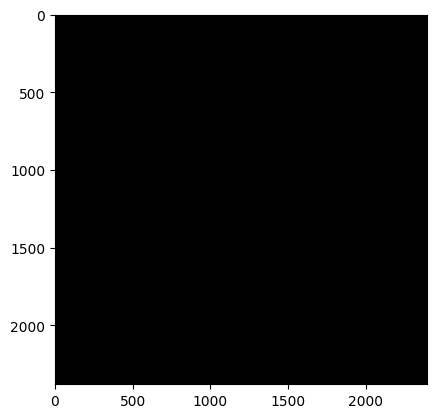

In [128]:
plt.imshow(image)

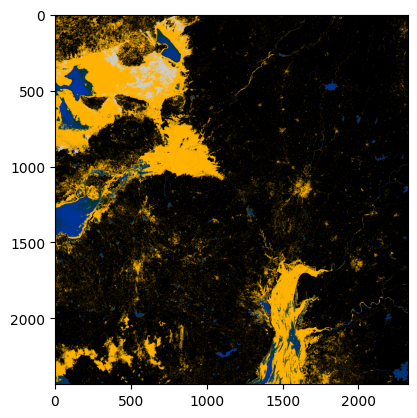

In [66]:
lms_mapping = get_suseptibility_mapping([cordinates[13][:2][1], cordinates[13][:2][0]], date_end="2025-02-20")
plt.imshow(lms_mapping)

In [60]:
tiles = int(math.sqrt(len(cordinates)))  
grid_size = 1000
image_size = grid_size * tiles

large_image = np.zeros((image_size, image_size,3))

for i, bbox in tqdm(enumerate(cordinates), total=len(cordinates), desc="Processing tiles"):
    col = i // tiles
    row = i % tiles

    x_start = col * grid_size
    y_start = (tiles - 1 - row) * grid_size  # Invert row for bottom-left filling

    # Extract correct lat/lon for bounding box
    min_lon, min_lat, max_lon, max_lat = bbox
    image = get_suseptibility_mapping([min_lat, min_lon])  # Should return (2450, 2450, 3)

    # Ensure image is correctly sized
    if image.shape[:2] != (grid_size, grid_size):
        print(f"Resizing image from {image.shape} to {(grid_size, grid_size)}")
        image = cv2.resize(image, (grid_size, grid_size))  # Resize if necessary

    large_image[y_start:y_start + grid_size, x_start:x_start + grid_size, :] = image
    plt.imsave("mapping2.png", large_image/255)


Processing tiles:   0%|          | 0/81 [00:00<?, ?it/s]

Resizing image from (2379, 2394, 3) to (1000, 1000)


Processing tiles:   1%|          | 1/81 [00:15<20:11, 15.15s/it]

Resizing image from (2378, 2392, 3) to (1000, 1000)


Processing tiles:   2%|▏         | 2/81 [00:31<20:35, 15.64s/it]

Resizing image from (2376, 2389, 3) to (1000, 1000)


Processing tiles:   4%|▎         | 3/81 [00:45<19:30, 15.00s/it]

Resizing image from (2375, 2386, 3) to (1000, 1000)


Processing tiles:   5%|▍         | 4/81 [00:58<18:15, 14.23s/it]

Resizing image from (2375, 2382, 3) to (1000, 1000)


Processing tiles:   6%|▌         | 5/81 [01:17<20:08, 15.90s/it]

Resizing image from (2375, 2378, 3) to (1000, 1000)


Processing tiles:   7%|▋         | 6/81 [01:35<20:48, 16.65s/it]

Resizing image from (2376, 2373, 3) to (1000, 1000)


Processing tiles:   9%|▊         | 7/81 [01:52<20:48, 16.88s/it]

Resizing image from (2377, 2367, 3) to (1000, 1000)


Processing tiles:  10%|▉         | 8/81 [02:09<20:30, 16.85s/it]

Resizing image from (2380, 2359, 3) to (1000, 1000)


Processing tiles:  11%|█         | 9/81 [02:24<19:40, 16.40s/it]

Resizing image from (2404, 2374, 3) to (1000, 1000)


Processing tiles:  12%|█▏        | 10/81 [02:38<18:29, 15.62s/it]

Resizing image from (2412, 2362, 3) to (1000, 1000)


Processing tiles:  14%|█▎        | 11/81 [02:52<17:32, 15.04s/it]

Resizing image from (2419, 2350, 3) to (1000, 1000)


Processing tiles:  15%|█▍        | 12/81 [03:07<17:07, 14.90s/it]

Resizing image from (2427, 2338, 3) to (1000, 1000)


Processing tiles:  16%|█▌        | 13/81 [03:21<16:40, 14.71s/it]

Resizing image from (2435, 2325, 3) to (1000, 1000)


Processing tiles:  17%|█▋        | 14/81 [03:35<16:22, 14.66s/it]

Resizing image from (2443, 2312, 3) to (1000, 1000)


Processing tiles:  19%|█▊        | 15/81 [03:50<16:08, 14.67s/it]

Resizing image from (2452, 2298, 3) to (1000, 1000)


Processing tiles:  20%|█▉        | 16/81 [04:07<16:29, 15.23s/it]

Resizing image from (2324, 2423, 3) to (1000, 1000)


Processing tiles:  21%|██        | 17/81 [04:25<17:08, 16.07s/it]

Resizing image from (2321, 2420, 3) to (1000, 1000)


Processing tiles:  22%|██▏       | 18/81 [04:44<17:52, 17.03s/it]

Resizing image from (2387, 2386, 3) to (1000, 1000)


Processing tiles:  23%|██▎       | 19/81 [05:01<17:42, 17.14s/it]

Resizing image from (2388, 2381, 3) to (1000, 1000)


Processing tiles:  25%|██▍       | 20/81 [05:18<17:26, 17.15s/it]

Resizing image from (2390, 2375, 3) to (1000, 1000)


Processing tiles:  26%|██▌       | 21/81 [05:35<17:03, 17.06s/it]

Resizing image from (2392, 2369, 3) to (1000, 1000)


Processing tiles:  27%|██▋       | 22/81 [05:50<15:57, 16.23s/it]

Resizing image from (2395, 2362, 3) to (1000, 1000)


Processing tiles:  28%|██▊       | 23/81 [06:05<15:28, 16.01s/it]

Resizing image from (2398, 2355, 3) to (1000, 1000)


Processing tiles:  30%|██▉       | 24/81 [06:20<14:44, 15.52s/it]

Resizing image from (2401, 2347, 3) to (1000, 1000)


Processing tiles:  31%|███       | 25/81 [06:34<14:13, 15.24s/it]

Resizing image from (2405, 2338, 3) to (1000, 1000)


Processing tiles:  32%|███▏      | 26/81 [06:49<13:57, 15.22s/it]

Resizing image from (2410, 2328, 3) to (1000, 1000)


Processing tiles:  33%|███▎      | 27/81 [07:04<13:37, 15.14s/it]

Resizing image from (2373, 2403, 3) to (1000, 1000)


Processing tiles:  35%|███▍      | 28/81 [07:22<14:12, 16.08s/it]

Resizing image from (2369, 2403, 3) to (1000, 1000)


Processing tiles:  36%|███▌      | 29/81 [07:40<14:25, 16.64s/it]

Resizing image from (2364, 2403, 3) to (1000, 1000)


Processing tiles:  37%|███▋      | 30/81 [08:01<15:09, 17.84s/it]

Resizing image from (2361, 2403, 3) to (1000, 1000)


Processing tiles:  38%|███▊      | 31/81 [08:20<15:14, 18.30s/it]

Resizing image from (2357, 2402, 3) to (1000, 1000)


Processing tiles:  40%|███▉      | 32/81 [08:39<15:00, 18.38s/it]

Resizing image from (2355, 2400, 3) to (1000, 1000)


Processing tiles:  41%|████      | 33/81 [08:55<14:08, 17.68s/it]

Resizing image from (2353, 2397, 3) to (1000, 1000)


Processing tiles:  42%|████▏     | 34/81 [09:11<13:22, 17.08s/it]

Resizing image from (2352, 2394, 3) to (1000, 1000)


Processing tiles:  43%|████▎     | 35/81 [09:27<12:59, 16.94s/it]

Resizing image from (2351, 2388, 3) to (1000, 1000)


Processing tiles:  44%|████▍     | 36/81 [09:43<12:21, 16.49s/it]

Resizing image from (2395, 2379, 3) to (1000, 1000)


Processing tiles:  46%|████▌     | 37/81 [09:57<11:40, 15.92s/it]

Resizing image from (2400, 2371, 3) to (1000, 1000)


Processing tiles:  47%|████▋     | 38/81 [10:12<11:09, 15.58s/it]

Resizing image from (2405, 2362, 3) to (1000, 1000)


Processing tiles:  48%|████▊     | 39/81 [10:28<11:01, 15.74s/it]

Resizing image from (2410, 2352, 3) to (1000, 1000)


Processing tiles:  49%|████▉     | 40/81 [10:44<10:44, 15.71s/it]

Resizing image from (2415, 2343, 3) to (1000, 1000)


Processing tiles:  51%|█████     | 41/81 [11:01<10:39, 16.00s/it]

Resizing image from (2421, 2332, 3) to (1000, 1000)


Processing tiles:  52%|█████▏    | 42/81 [11:18<10:40, 16.42s/it]

Resizing image from (2427, 2321, 3) to (1000, 1000)


Processing tiles:  53%|█████▎    | 43/81 [11:36<10:41, 16.88s/it]

Resizing image from (2434, 2310, 3) to (1000, 1000)


Processing tiles:  54%|█████▍    | 44/81 [11:57<11:10, 18.13s/it]

Resizing image from (2441, 2297, 3) to (1000, 1000)


Processing tiles:  56%|█████▌    | 45/81 [12:16<10:57, 18.27s/it]

Resizing image from (2380, 2394, 3) to (1000, 1000)


Processing tiles:  57%|█████▋    | 46/81 [12:30<10:01, 17.19s/it]

Resizing image from (2378, 2391, 3) to (1000, 1000)


Processing tiles:  58%|█████▊    | 47/81 [12:47<09:36, 16.94s/it]

Resizing image from (2377, 2388, 3) to (1000, 1000)


Processing tiles:  59%|█████▉    | 48/81 [13:02<09:02, 16.45s/it]

Resizing image from (2377, 2385, 3) to (1000, 1000)


Processing tiles:  60%|██████    | 49/81 [13:17<08:37, 16.16s/it]

Resizing image from (2376, 2381, 3) to (1000, 1000)


Processing tiles:  62%|██████▏   | 50/81 [13:32<08:10, 15.82s/it]

Resizing image from (2377, 2376, 3) to (1000, 1000)


Processing tiles:  63%|██████▎   | 51/81 [13:51<08:20, 16.67s/it]

Resizing image from (2378, 2371, 3) to (1000, 1000)


Processing tiles:  64%|██████▍   | 52/81 [14:07<07:57, 16.47s/it]

Resizing image from (2379, 2364, 3) to (1000, 1000)


Processing tiles:  65%|██████▌   | 53/81 [14:24<07:48, 16.74s/it]

Resizing image from (2382, 2357, 3) to (1000, 1000)


Processing tiles:  67%|██████▋   | 54/81 [14:43<07:48, 17.34s/it]

Resizing image from (2405, 2374, 3) to (1000, 1000)


Processing tiles:  68%|██████▊   | 55/81 [15:00<07:28, 17.24s/it]

Resizing image from (2412, 2362, 3) to (1000, 1000)


Processing tiles:  69%|██████▉   | 56/81 [15:21<07:37, 18.31s/it]

Resizing image from (2420, 2349, 3) to (1000, 1000)


Processing tiles:  70%|███████   | 57/81 [15:38<07:07, 17.81s/it]

Resizing image from (2428, 2337, 3) to (1000, 1000)


Processing tiles:  72%|███████▏  | 58/81 [15:54<06:42, 17.51s/it]

Resizing image from (2437, 2324, 3) to (1000, 1000)


Processing tiles:  73%|███████▎  | 59/81 [16:11<06:16, 17.13s/it]

Resizing image from (2445, 2310, 3) to (1000, 1000)


Processing tiles:  74%|███████▍  | 60/81 [16:26<05:48, 16.58s/it]

Resizing image from (2330, 2422, 3) to (1000, 1000)


Processing tiles:  75%|███████▌  | 61/81 [16:41<05:19, 15.98s/it]

Resizing image from (2326, 2421, 3) to (1000, 1000)


Processing tiles:  77%|███████▋  | 62/81 [16:56<04:57, 15.68s/it]

Resizing image from (2323, 2418, 3) to (1000, 1000)


Processing tiles:  78%|███████▊  | 63/81 [17:11<04:41, 15.64s/it]

Resizing image from (2387, 2386, 3) to (1000, 1000)


Processing tiles:  79%|███████▉  | 64/81 [17:27<04:25, 15.61s/it]

Resizing image from (2389, 2380, 3) to (1000, 1000)


Processing tiles:  80%|████████  | 65/81 [17:43<04:14, 15.92s/it]

Resizing image from (2391, 2374, 3) to (1000, 1000)


Processing tiles:  81%|████████▏ | 66/81 [18:00<04:03, 16.23s/it]

Resizing image from (2393, 2367, 3) to (1000, 1000)


Processing tiles:  83%|████████▎ | 67/81 [18:20<04:00, 17.17s/it]

Resizing image from (2396, 2361, 3) to (1000, 1000)


Processing tiles:  84%|████████▍ | 68/81 [18:39<03:50, 17.74s/it]

Resizing image from (2399, 2353, 3) to (1000, 1000)


Processing tiles:  85%|████████▌ | 69/81 [18:58<03:38, 18.17s/it]

Resizing image from (2403, 2345, 3) to (1000, 1000)


Processing tiles:  86%|████████▋ | 70/81 [19:17<03:23, 18.51s/it]

Resizing image from (2408, 2336, 3) to (1000, 1000)


Processing tiles:  88%|████████▊ | 71/81 [19:36<03:06, 18.65s/it]

Resizing image from (2413, 2325, 3) to (1000, 1000)


Processing tiles:  89%|████████▉ | 72/81 [19:53<02:43, 18.15s/it]

Resizing image from (2374, 2402, 3) to (1000, 1000)


Processing tiles:  90%|█████████ | 73/81 [20:11<02:25, 18.13s/it]

Resizing image from (2369, 2402, 3) to (1000, 1000)


Processing tiles:  91%|█████████▏| 74/81 [20:26<02:00, 17.24s/it]

Resizing image from (2365, 2402, 3) to (1000, 1000)


Processing tiles:  93%|█████████▎| 75/81 [20:42<01:40, 16.73s/it]

Resizing image from (2362, 2401, 3) to (1000, 1000)


Processing tiles:  94%|█████████▍| 76/81 [20:59<01:23, 16.71s/it]

Resizing image from (2359, 2400, 3) to (1000, 1000)


Processing tiles:  95%|█████████▌| 77/81 [21:14<01:05, 16.32s/it]

Resizing image from (2356, 2398, 3) to (1000, 1000)


Processing tiles:  96%|█████████▋| 78/81 [21:30<00:48, 16.26s/it]

Resizing image from (2355, 2395, 3) to (1000, 1000)


Processing tiles:  98%|█████████▊| 79/81 [21:49<00:34, 17.00s/it]

Resizing image from (2354, 2391, 3) to (1000, 1000)


Processing tiles:  99%|█████████▉| 80/81 [22:11<00:18, 18.58s/it]

Resizing image from (2354, 2386, 3) to (1000, 1000)


Processing tiles: 100%|██████████| 81/81 [22:31<00:00, 16.68s/it]
